In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [4]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [5]:
X.shape

(16396, 224, 224, 3)

In [6]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [7]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False)

In [10]:
filename = 'cg-inceptionv3features.npy'
if os.path.exists(filename):
    print("Loading Inceptionv3 extracted features from %s ..." %(filename))
    inceptionv3features = np.load(filename)
else:
    print("Extracting features from Inceptionv3 layers ...")
    inceptionv3features = base_model.predict(X)
    print("Saving Inceptionv3 extracted features into %s ..." %(filename))
    np.save(filename, inceptionv3features)

Loading Inceptionv3 extracted features from cg-inceptionv3features.npy ...


In [11]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [18]:
# Training top_model and saving min training loss weights
num_epochs=400
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-inceptionv3-1layer-160neurons-relu-Adam-400epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = inceptionv3features[train_indices]
    Y_train = Y[train_indices]
    X_test = inceptionv3features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=inceptionv3features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    x = Dense(160, activation='relu', name='fc1')(x)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 14755 samples, validate on 1641 samples
Epoch 1/400
14755/14755 [==============================] - 3s - loss: 0.8444 - acc: 0.4933 - val_loss: 4.0262 - val_acc: 0.4881
Epoch 2/400
14755/14755 [==============================] - 2s - loss: 4.0091 - acc: 0.4880 - val_loss: 1.1451 - val_acc: 0.5015
Epoch 3/400
14755/14755 [==============================] - 2s - loss: 1.1399 - acc: 0.5058 - val_loss: 1.1372 - val_acc: 0.5137
Epoch 4/400
14755/14755 [==============================] - 2s - loss: 1.1286 - acc: 0.5153 - val_loss: 1.5764 - val_acc: 0.5119
Epoch 5/400
14755/14755 [==============================] - 2s - loss: 1.5678 - acc: 0.5120 - val_loss: 1.2679 - val_acc: 0.5119
Epoch 6/400
14755/14755 [==============================] - 2s - loss: 1.2618 - acc: 0.5120 - val_loss: 0.8499 - val_acc: 0.5204
Epoch 7/400
14755/14755 [==============================] - 2s - loss: 0.8472 - acc: 0.5221 - val_loss: 0.5950 - val_acc: 0.6350
Epoch 8/400
14755/14755 [==============================

14755/14755 [==============================] - 2s - loss: 0.1815 - acc: 0.9297 - val_loss: 0.2302 - val_acc: 0.9043
Epoch 128/400
14755/14755 [==============================] - 2s - loss: 0.1806 - acc: 0.9304 - val_loss: 0.2299 - val_acc: 0.9031
Epoch 129/400
14755/14755 [==============================] - 2s - loss: 0.1798 - acc: 0.9300 - val_loss: 0.2299 - val_acc: 0.9049
Epoch 130/400
14755/14755 [==============================] - 2s - loss: 0.1790 - acc: 0.9309 - val_loss: 0.2296 - val_acc: 0.9037
Epoch 131/400
14755/14755 [==============================] - 2s - loss: 0.1782 - acc: 0.9307 - val_loss: 0.2295 - val_acc: 0.9055
Epoch 132/400
14755/14755 [==============================] - 2s - loss: 0.1773 - acc: 0.9315 - val_loss: 0.2293 - val_acc: 0.9049
Epoch 133/400
14755/14755 [==============================] - 2s - loss: 0.1765 - acc: 0.9320 - val_loss: 0.2291 - val_acc: 0.9049
Epoch 134/400
14755/14755 [==============================] - 2s - loss: 0.1757 - acc: 0.9319 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.1165 - acc: 0.9585 - val_loss: 0.2363 - val_acc: 0.9098
Epoch 254/400
14755/14755 [==============================] - 2s - loss: 0.1162 - acc: 0.9585 - val_loss: 0.2361 - val_acc: 0.9104
Epoch 255/400
14755/14755 [==============================] - 2s - loss: 0.1159 - acc: 0.9587 - val_loss: 0.2368 - val_acc: 0.9110
Epoch 256/400
14755/14755 [==============================] - 2s - loss: 0.1157 - acc: 0.9592 - val_loss: 0.2365 - val_acc: 0.9092
Epoch 257/400
14755/14755 [==============================] - 2s - loss: 0.1154 - acc: 0.9586 - val_loss: 0.2372 - val_acc: 0.9098
Epoch 258/400
14755/14755 [==============================] - 2s - loss: 0.1151 - acc: 0.9594 - val_loss: 0.2368 - val_acc: 0.9092
Epoch 259/400
14755/14755 [==============================] - 2s - loss: 0.1147 - acc: 0.9591 - val_loss: 0.2372 - val_acc: 0.9104
Epoch 260/400
14755/14755 [==============================] - 3s - loss: 0.1142 - acc: 0.9596 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0834 - acc: 0.9730 - val_loss: 0.2579 - val_acc: 0.9062
Epoch 380/400
14755/14755 [==============================] - 2s - loss: 0.0832 - acc: 0.9738 - val_loss: 0.2589 - val_acc: 0.9092
Epoch 381/400
14755/14755 [==============================] - 2s - loss: 0.0828 - acc: 0.9732 - val_loss: 0.2583 - val_acc: 0.9068
Epoch 382/400
14755/14755 [==============================] - 2s - loss: 0.0825 - acc: 0.9739 - val_loss: 0.2590 - val_acc: 0.9074
Epoch 383/400
14755/14755 [==============================] - 2s - loss: 0.0822 - acc: 0.9732 - val_loss: 0.2589 - val_acc: 0.9080
Epoch 384/400
14755/14755 [==============================] - 2s - loss: 0.0820 - acc: 0.9741 - val_loss: 0.2592 - val_acc: 0.9074
Epoch 385/400
14755/14755 [==============================] - 2s - loss: 0.0817 - acc: 0.9738 - val_loss: 0.2594 - val_acc: 0.9074
Epoch 386/400
14755/14755 [==============================] - 2s - loss: 0.0815 - acc: 0.9739 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.2169 - acc: 0.9118 - val_loss: 0.2344 - val_acc: 0.9062
Epoch 105/400
14755/14755 [==============================] - 2s - loss: 0.2158 - acc: 0.9120 - val_loss: 0.2336 - val_acc: 0.9074
Epoch 106/400
14755/14755 [==============================] - 2s - loss: 0.2147 - acc: 0.9122 - val_loss: 0.2329 - val_acc: 0.9068
Epoch 107/400
14755/14755 [==============================] - 2s - loss: 0.2137 - acc: 0.9132 - val_loss: 0.2322 - val_acc: 0.9074
Epoch 108/400
14755/14755 [==============================] - 2s - loss: 0.2126 - acc: 0.9137 - val_loss: 0.2314 - val_acc: 0.9092
Epoch 109/400
14755/14755 [==============================] - 2s - loss: 0.2116 - acc: 0.9138 - val_loss: 0.2307 - val_acc: 0.9098
Epoch 110/400
14755/14755 [==============================] - 2s - loss: 0.2106 - acc: 0.9145 - val_loss: 0.2301 - val_acc: 0.9086
Epoch 111/400
14755/14755 [==============================] - 2s - loss: 0.2095 - acc: 0.9153 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.1418 - acc: 0.9475 - val_loss: 0.2070 - val_acc: 0.9183
Epoch 231/400
14755/14755 [==============================] - 2s - loss: 0.1413 - acc: 0.9480 - val_loss: 0.2070 - val_acc: 0.9183
Epoch 232/400
14755/14755 [==============================] - 2s - loss: 0.1409 - acc: 0.9481 - val_loss: 0.2070 - val_acc: 0.9183
Epoch 233/400
14755/14755 [==============================] - 2s - loss: 0.1405 - acc: 0.9484 - val_loss: 0.2070 - val_acc: 0.9196
Epoch 234/400
14755/14755 [==============================] - 2s - loss: 0.1400 - acc: 0.9488 - val_loss: 0.2068 - val_acc: 0.9196
Epoch 235/400
14755/14755 [==============================] - 2s - loss: 0.1396 - acc: 0.9488 - val_loss: 0.2076 - val_acc: 0.9196
Epoch 236/400
14755/14755 [==============================] - 2s - loss: 0.1394 - acc: 0.9488 - val_loss: 0.2065 - val_acc: 0.9159
Epoch 237/400
14755/14755 [==============================] - 2s - loss: 0.1396 - acc: 0.9481 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0999 - acc: 0.9662 - val_loss: 0.2104 - val_acc: 0.9208
Epoch 357/400
14755/14755 [==============================] - 2s - loss: 0.0998 - acc: 0.9658 - val_loss: 0.2106 - val_acc: 0.9177
Epoch 358/400
14755/14755 [==============================] - 2s - loss: 0.0996 - acc: 0.9661 - val_loss: 0.2104 - val_acc: 0.9208
Epoch 359/400
14755/14755 [==============================] - 2s - loss: 0.0992 - acc: 0.9658 - val_loss: 0.2108 - val_acc: 0.9202
Epoch 360/400
14755/14755 [==============================] - 2s - loss: 0.0987 - acc: 0.9665 - val_loss: 0.2104 - val_acc: 0.9214
Epoch 361/400
14755/14755 [==============================] - 2s - loss: 0.0983 - acc: 0.9663 - val_loss: 0.2104 - val_acc: 0.9214
Epoch 362/400
14755/14755 [==============================] - 2s - loss: 0.0980 - acc: 0.9671 - val_loss: 0.2108 - val_acc: 0.9220
Epoch 363/400
14755/14755 [==============================] - 2s - loss: 0.0977 - acc: 0.9676 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.1895 - acc: 0.9257 - val_loss: 0.2238 - val_acc: 0.9098
Epoch 82/400
14756/14756 [==============================] - 2s - loss: 0.1883 - acc: 0.9261 - val_loss: 0.2234 - val_acc: 0.9091
Epoch 83/400
14756/14756 [==============================] - 2s - loss: 0.1871 - acc: 0.9271 - val_loss: 0.2229 - val_acc: 0.9091
Epoch 84/400
14756/14756 [==============================] - 2s - loss: 0.1859 - acc: 0.9276 - val_loss: 0.2222 - val_acc: 0.9079
Epoch 85/400
14756/14756 [==============================] - 2s - loss: 0.1847 - acc: 0.9283 - val_loss: 0.2218 - val_acc: 0.9085
Epoch 86/400
14756/14756 [==============================] - 2s - loss: 0.1836 - acc: 0.9284 - val_loss: 0.2213 - val_acc: 0.9073
Epoch 87/400
14756/14756 [==============================] - 2s - loss: 0.1825 - acc: 0.9295 - val_loss: 0.2209 - val_acc: 0.9085
Epoch 88/400
14756/14756 [==============================] - 2s - loss: 0.1814 - acc: 0.9297 - val_loss: 0.2203

14756/14756 [==============================] - 2s - loss: 0.0802 - acc: 0.9766 - val_loss: 0.2158 - val_acc: 0.9098
Epoch 208/400
14756/14756 [==============================] - 2s - loss: 0.0799 - acc: 0.9770 - val_loss: 0.2163 - val_acc: 0.9104
Epoch 209/400
14756/14756 [==============================] - 2s - loss: 0.0797 - acc: 0.9771 - val_loss: 0.2169 - val_acc: 0.9085
Epoch 210/400
14756/14756 [==============================] - 2s - loss: 0.0797 - acc: 0.9767 - val_loss: 0.2174 - val_acc: 0.9091
Epoch 211/400
14756/14756 [==============================] - 2s - loss: 0.0792 - acc: 0.9772 - val_loss: 0.2174 - val_acc: 0.9085
Epoch 212/400
14756/14756 [==============================] - 2s - loss: 0.0788 - acc: 0.9770 - val_loss: 0.2169 - val_acc: 0.9104
Epoch 213/400
14756/14756 [==============================] - 2s - loss: 0.0774 - acc: 0.9780 - val_loss: 0.2163 - val_acc: 0.9098
Epoch 214/400
14756/14756 [==============================] - 2s - loss: 0.0763 - acc: 0.9786 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0323 - acc: 0.9967 - val_loss: 0.2433 - val_acc: 0.9134
Epoch 334/400
14756/14756 [==============================] - 2s - loss: 0.0319 - acc: 0.9966 - val_loss: 0.2433 - val_acc: 0.9140
Epoch 335/400
14756/14756 [==============================] - 2s - loss: 0.0317 - acc: 0.9966 - val_loss: 0.2440 - val_acc: 0.9140
Epoch 336/400
14756/14756 [==============================] - 2s - loss: 0.0315 - acc: 0.9968 - val_loss: 0.2443 - val_acc: 0.9116
Epoch 337/400
14756/14756 [==============================] - 2s - loss: 0.0313 - acc: 0.9967 - val_loss: 0.2451 - val_acc: 0.9128
Epoch 338/400
14756/14756 [==============================] - 2s - loss: 0.0311 - acc: 0.9968 - val_loss: 0.2447 - val_acc: 0.9122
Epoch 339/400
14756/14756 [==============================] - 2s - loss: 0.0308 - acc: 0.9968 - val_loss: 0.2451 - val_acc: 0.9134
Epoch 340/400
14756/14756 [==============================] - 2s - loss: 0.0306 - acc: 0.9970 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.2576 - acc: 0.8906 - val_loss: 0.2728 - val_acc: 0.8854
Epoch 60/400
14756/14756 [==============================] - 2s - loss: 0.2566 - acc: 0.8921 - val_loss: 0.2715 - val_acc: 0.8860
Epoch 61/400
14756/14756 [==============================] - 2s - loss: 0.2550 - acc: 0.8929 - val_loss: 0.2700 - val_acc: 0.8890
Epoch 62/400
14756/14756 [==============================] - 2s - loss: 0.2527 - acc: 0.8929 - val_loss: 0.2695 - val_acc: 0.8866
Epoch 63/400
14756/14756 [==============================] - 2s - loss: 0.2513 - acc: 0.8929 - val_loss: 0.2689 - val_acc: 0.8872
Epoch 64/400
14756/14756 [==============================] - 2s - loss: 0.2501 - acc: 0.8939 - val_loss: 0.2669 - val_acc: 0.8872
Epoch 65/400
14756/14756 [==============================] - 2s - loss: 0.2482 - acc: 0.8952 - val_loss: 0.2650 - val_acc: 0.8915
Epoch 66/400
14756/14756 [==============================] - 2s - loss: 0.2465 - acc: 0.8966 - val_loss: 0.2638

14756/14756 [==============================] - 2s - loss: 0.1533 - acc: 0.9405 - val_loss: 0.2111 - val_acc: 0.9098
Epoch 186/400
14756/14756 [==============================] - 2s - loss: 0.1528 - acc: 0.9406 - val_loss: 0.2111 - val_acc: 0.9091
Epoch 187/400
14756/14756 [==============================] - 2s - loss: 0.1523 - acc: 0.9411 - val_loss: 0.2110 - val_acc: 0.9091
Epoch 188/400
14756/14756 [==============================] - 2s - loss: 0.1519 - acc: 0.9413 - val_loss: 0.2110 - val_acc: 0.9091
Epoch 189/400
14756/14756 [==============================] - 2s - loss: 0.1514 - acc: 0.9414 - val_loss: 0.2108 - val_acc: 0.9091
Epoch 190/400
14756/14756 [==============================] - 2s - loss: 0.1510 - acc: 0.9417 - val_loss: 0.2109 - val_acc: 0.9085
Epoch 191/400
14756/14756 [==============================] - 2s - loss: 0.1505 - acc: 0.9418 - val_loss: 0.2107 - val_acc: 0.9085
Epoch 192/400
14756/14756 [==============================] - 2s - loss: 0.1501 - acc: 0.9421 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.1109 - acc: 0.9616 - val_loss: 0.2122 - val_acc: 0.9104
Epoch 312/400
14756/14756 [==============================] - 2s - loss: 0.1106 - acc: 0.9618 - val_loss: 0.2116 - val_acc: 0.9122
Epoch 313/400
14756/14756 [==============================] - 2s - loss: 0.1105 - acc: 0.9612 - val_loss: 0.2130 - val_acc: 0.9104
Epoch 314/400
14756/14756 [==============================] - 2s - loss: 0.1103 - acc: 0.9624 - val_loss: 0.2115 - val_acc: 0.9134
Epoch 315/400
14756/14756 [==============================] - 2s - loss: 0.1101 - acc: 0.9613 - val_loss: 0.2131 - val_acc: 0.9104
Epoch 316/400
14756/14756 [==============================] - 2s - loss: 0.1098 - acc: 0.9624 - val_loss: 0.2116 - val_acc: 0.9128
Epoch 317/400
14756/14756 [==============================] - 2s - loss: 0.1095 - acc: 0.9616 - val_loss: 0.2125 - val_acc: 0.9110
Epoch 318/400
14756/14756 [==============================] - 2s - loss: 0.1091 - acc: 0.9626 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.2734 - acc: 0.8799 - val_loss: 0.2675 - val_acc: 0.8877
Epoch 37/400
14757/14757 [==============================] - 2s - loss: 0.2668 - acc: 0.8862 - val_loss: 0.2695 - val_acc: 0.8859
Epoch 38/400
14757/14757 [==============================] - 2s - loss: 0.2675 - acc: 0.8853 - val_loss: 0.2718 - val_acc: 0.8853
Epoch 39/400
14757/14757 [==============================] - 2s - loss: 0.2690 - acc: 0.8839 - val_loss: 0.2681 - val_acc: 0.8890
Epoch 40/400
14757/14757 [==============================] - 2s - loss: 0.2649 - acc: 0.8867 - val_loss: 0.2619 - val_acc: 0.8938
Epoch 41/400
14757/14757 [==============================] - 2s - loss: 0.2586 - acc: 0.8900 - val_loss: 0.2596 - val_acc: 0.8957
Epoch 42/400
14757/14757 [==============================] - 2s - loss: 0.2571 - acc: 0.8895 - val_loss: 0.2604 - val_acc: 0.8951
Epoch 43/400
14757/14757 [==============================] - 2s - loss: 0.2585 - acc: 0.8878 - val_loss: 0.2581

14757/14757 [==============================] - 2s - loss: 0.0862 - acc: 0.9747 - val_loss: 0.1727 - val_acc: 0.9304
Epoch 163/400
14757/14757 [==============================] - 2s - loss: 0.0857 - acc: 0.9748 - val_loss: 0.1733 - val_acc: 0.9323
Epoch 164/400
14757/14757 [==============================] - 2s - loss: 0.0852 - acc: 0.9749 - val_loss: 0.1725 - val_acc: 0.9298
Epoch 165/400
14757/14757 [==============================] - 2s - loss: 0.0842 - acc: 0.9759 - val_loss: 0.1725 - val_acc: 0.9335
Epoch 166/400
14757/14757 [==============================] - 2s - loss: 0.0831 - acc: 0.9757 - val_loss: 0.1721 - val_acc: 0.9323
Epoch 167/400
14757/14757 [==============================] - 2s - loss: 0.0821 - acc: 0.9764 - val_loss: 0.1720 - val_acc: 0.9323
Epoch 168/400
14757/14757 [==============================] - 2s - loss: 0.0813 - acc: 0.9768 - val_loss: 0.1722 - val_acc: 0.9341
Epoch 169/400
14757/14757 [==============================] - 2s - loss: 0.0807 - acc: 0.9772 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0247 - acc: 0.9984 - val_loss: 0.1787 - val_acc: 0.9372
Epoch 289/400
14757/14757 [==============================] - 2s - loss: 0.0244 - acc: 0.9983 - val_loss: 0.1788 - val_acc: 0.9359
Epoch 290/400
14757/14757 [==============================] - 2s - loss: 0.0242 - acc: 0.9984 - val_loss: 0.1789 - val_acc: 0.9353
Epoch 291/400
14757/14757 [==============================] - 2s - loss: 0.0239 - acc: 0.9984 - val_loss: 0.1793 - val_acc: 0.9347
Epoch 292/400
14757/14757 [==============================] - 2s - loss: 0.0237 - acc: 0.9986 - val_loss: 0.1793 - val_acc: 0.9347
Epoch 293/400
14757/14757 [==============================] - 2s - loss: 0.0234 - acc: 0.9986 - val_loss: 0.1793 - val_acc: 0.9335
Epoch 294/400
14757/14757 [==============================] - 2s - loss: 0.0232 - acc: 0.9986 - val_loss: 0.1795 - val_acc: 0.9335
Epoch 295/400
14757/14757 [==============================] - 2s - loss: 0.0230 - acc: 0.9987 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.5178 - acc: 0.7594 - val_loss: 0.5642 - val_acc: 0.6809
Epoch 14/400
14757/14757 [==============================] - 2s - loss: 0.5687 - acc: 0.6835 - val_loss: 0.5621 - val_acc: 0.6779
Epoch 15/400
14757/14757 [==============================] - 2s - loss: 0.5654 - acc: 0.6810 - val_loss: 0.5267 - val_acc: 0.7267
Epoch 16/400
14757/14757 [==============================] - 2s - loss: 0.5293 - acc: 0.7238 - val_loss: 0.4889 - val_acc: 0.7822
Epoch 17/400
14757/14757 [==============================] - 2s - loss: 0.4907 - acc: 0.7770 - val_loss: 0.4604 - val_acc: 0.8145
Epoch 18/400
14757/14757 [==============================] - 2s - loss: 0.4601 - acc: 0.8116 - val_loss: 0.4397 - val_acc: 0.8261
Epoch 19/400
14757/14757 [==============================] - 2s - loss: 0.4374 - acc: 0.8271 - val_loss: 0.4230 - val_acc: 0.8243
Epoch 20/400
14757/14757 [==============================] - 2s - loss: 0.4188 - acc: 0.8313 - val_loss: 0.4067

14757/14757 [==============================] - 2s - loss: 0.1468 - acc: 0.9454 - val_loss: 0.1920 - val_acc: 0.9268
Epoch 140/400
14757/14757 [==============================] - 2s - loss: 0.1460 - acc: 0.9444 - val_loss: 0.1922 - val_acc: 0.9256
Epoch 141/400
14757/14757 [==============================] - 2s - loss: 0.1452 - acc: 0.9463 - val_loss: 0.1915 - val_acc: 0.9274
Epoch 142/400
14757/14757 [==============================] - 2s - loss: 0.1444 - acc: 0.9456 - val_loss: 0.1914 - val_acc: 0.9280
Epoch 143/400
14757/14757 [==============================] - 2s - loss: 0.1436 - acc: 0.9465 - val_loss: 0.1911 - val_acc: 0.9280
Epoch 144/400
14757/14757 [==============================] - 2s - loss: 0.1429 - acc: 0.9465 - val_loss: 0.1909 - val_acc: 0.9280
Epoch 145/400
14757/14757 [==============================] - 2s - loss: 0.1423 - acc: 0.9467 - val_loss: 0.1909 - val_acc: 0.9280
Epoch 146/400
14757/14757 [==============================] - 2s - loss: 0.1416 - acc: 0.9478 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0857 - acc: 0.9742 - val_loss: 0.1881 - val_acc: 0.9268
Epoch 266/400
14757/14757 [==============================] - 3s - loss: 0.0854 - acc: 0.9743 - val_loss: 0.1883 - val_acc: 0.9262
Epoch 267/400
14757/14757 [==============================] - 3s - loss: 0.0850 - acc: 0.9743 - val_loss: 0.1884 - val_acc: 0.9298
Epoch 268/400
14757/14757 [==============================] - 3s - loss: 0.0847 - acc: 0.9745 - val_loss: 0.1887 - val_acc: 0.9274
Epoch 269/400
14757/14757 [==============================] - 3s - loss: 0.0846 - acc: 0.9746 - val_loss: 0.1892 - val_acc: 0.9311
Epoch 270/400
14757/14757 [==============================] - 3s - loss: 0.0847 - acc: 0.9735 - val_loss: 0.1901 - val_acc: 0.9280
Epoch 271/400
14757/14757 [==============================] - 3s - loss: 0.0851 - acc: 0.9736 - val_loss: 0.1914 - val_acc: 0.9298
Epoch 272/400
14757/14757 [==============================] - 3s - loss: 0.0861 - acc: 0.9727 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0512 - acc: 0.9892 - val_loss: 0.2015 - val_acc: 0.9311
Epoch 392/400
14757/14757 [==============================] - 3s - loss: 0.0511 - acc: 0.9893 - val_loss: 0.2015 - val_acc: 0.9311
Epoch 393/400
14757/14757 [==============================] - 3s - loss: 0.0510 - acc: 0.9890 - val_loss: 0.2022 - val_acc: 0.9317
Epoch 394/400
14757/14757 [==============================] - 3s - loss: 0.0511 - acc: 0.9888 - val_loss: 0.2019 - val_acc: 0.9304
Epoch 395/400
14757/14757 [==============================] - 3s - loss: 0.0514 - acc: 0.9888 - val_loss: 0.2034 - val_acc: 0.9317
Epoch 396/400
14757/14757 [==============================] - 3s - loss: 0.0515 - acc: 0.9885 - val_loss: 0.2028 - val_acc: 0.9304
Epoch 397/400
14757/14757 [==============================] - 3s - loss: 0.0515 - acc: 0.9887 - val_loss: 0.2036 - val_acc: 0.9317
Epoch 398/400
14757/14757 [==============================] - 3s - loss: 0.0508 - acc: 0.9889 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2390 - acc: 0.9010 - val_loss: 0.2361 - val_acc: 0.9054
Epoch 55/400
14757/14757 [==============================] - 3s - loss: 0.2368 - acc: 0.9026 - val_loss: 0.2348 - val_acc: 0.9054
Epoch 56/400
14757/14757 [==============================] - 3s - loss: 0.2348 - acc: 0.9041 - val_loss: 0.2335 - val_acc: 0.9067
Epoch 57/400
14757/14757 [==============================] - 3s - loss: 0.2328 - acc: 0.9048 - val_loss: 0.2322 - val_acc: 0.9060
Epoch 58/400
14757/14757 [==============================] - 3s - loss: 0.2308 - acc: 0.9053 - val_loss: 0.2310 - val_acc: 0.9060
Epoch 59/400
14757/14757 [==============================] - 3s - loss: 0.2289 - acc: 0.9063 - val_loss: 0.2298 - val_acc: 0.9060
Epoch 60/400
14757/14757 [==============================] - 3s - loss: 0.2270 - acc: 0.9072 - val_loss: 0.2287 - val_acc: 0.9067
Epoch 61/400
14757/14757 [==============================] - 3s - loss: 0.2253 - acc: 0.9083 - val_loss: 0.2276

14757/14757 [==============================] - 3s - loss: 0.1239 - acc: 0.9544 - val_loss: 0.2060 - val_acc: 0.9213
Epoch 181/400
14757/14757 [==============================] - 3s - loss: 0.1239 - acc: 0.9545 - val_loss: 0.2051 - val_acc: 0.9225
Epoch 182/400
14757/14757 [==============================] - 3s - loss: 0.1241 - acc: 0.9538 - val_loss: 0.2070 - val_acc: 0.9213
Epoch 183/400
14757/14757 [==============================] - 3s - loss: 0.1236 - acc: 0.9543 - val_loss: 0.2049 - val_acc: 0.9225
Epoch 184/400
14757/14757 [==============================] - 3s - loss: 0.1227 - acc: 0.9545 - val_loss: 0.2051 - val_acc: 0.9213
Epoch 185/400
14757/14757 [==============================] - 3s - loss: 0.1210 - acc: 0.9562 - val_loss: 0.2041 - val_acc: 0.9237
Epoch 186/400
14757/14757 [==============================] - 3s - loss: 0.1199 - acc: 0.9572 - val_loss: 0.2042 - val_acc: 0.9231
Epoch 187/400
14757/14757 [==============================] - 3s - loss: 0.1197 - acc: 0.9570 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0699 - acc: 0.9800 - val_loss: 0.2129 - val_acc: 0.9286
Epoch 307/400
14757/14757 [==============================] - 3s - loss: 0.0693 - acc: 0.9804 - val_loss: 0.2128 - val_acc: 0.9274
Epoch 308/400
14757/14757 [==============================] - 3s - loss: 0.0692 - acc: 0.9806 - val_loss: 0.2140 - val_acc: 0.9274
Epoch 309/400
14757/14757 [==============================] - 3s - loss: 0.0690 - acc: 0.9807 - val_loss: 0.2133 - val_acc: 0.9250
Epoch 310/400
14757/14757 [==============================] - 3s - loss: 0.0690 - acc: 0.9803 - val_loss: 0.2150 - val_acc: 0.9274
Epoch 311/400
14757/14757 [==============================] - 3s - loss: 0.0688 - acc: 0.9806 - val_loss: 0.2134 - val_acc: 0.9250
Epoch 312/400
14757/14757 [==============================] - 3s - loss: 0.0686 - acc: 0.9810 - val_loss: 0.2146 - val_acc: 0.9280
Epoch 313/400
14757/14757 [==============================] - 3s - loss: 0.0681 - acc: 0.9813 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.3218 - acc: 0.8609 - val_loss: 0.3297 - val_acc: 0.8578
Epoch 32/400
14757/14757 [==============================] - 3s - loss: 0.3168 - acc: 0.8644 - val_loss: 0.3272 - val_acc: 0.8585
Epoch 33/400
14757/14757 [==============================] - 3s - loss: 0.3134 - acc: 0.8646 - val_loss: 0.3214 - val_acc: 0.8597
Epoch 34/400
14757/14757 [==============================] - 3s - loss: 0.3083 - acc: 0.8679 - val_loss: 0.3152 - val_acc: 0.8658
Epoch 35/400
14757/14757 [==============================] - 3s - loss: 0.3036 - acc: 0.8700 - val_loss: 0.3112 - val_acc: 0.8755
Epoch 36/400
14757/14757 [==============================] - 3s - loss: 0.3009 - acc: 0.8702 - val_loss: 0.3075 - val_acc: 0.8774
Epoch 37/400
14757/14757 [==============================] - 3s - loss: 0.2968 - acc: 0.8717 - val_loss: 0.3045 - val_acc: 0.8725
Epoch 38/400
14757/14757 [==============================] - 3s - loss: 0.2926 - acc: 0.8749 - val_loss: 0.3028

14757/14757 [==============================] - 3s - loss: 0.1436 - acc: 0.9467 - val_loss: 0.2117 - val_acc: 0.9176
Epoch 158/400
14757/14757 [==============================] - 3s - loss: 0.1427 - acc: 0.9471 - val_loss: 0.2116 - val_acc: 0.9170
Epoch 159/400
14757/14757 [==============================] - 3s - loss: 0.1420 - acc: 0.9473 - val_loss: 0.2115 - val_acc: 0.9158
Epoch 160/400
14757/14757 [==============================] - 3s - loss: 0.1413 - acc: 0.9474 - val_loss: 0.2115 - val_acc: 0.9140
Epoch 161/400
14757/14757 [==============================] - 3s - loss: 0.1407 - acc: 0.9482 - val_loss: 0.2115 - val_acc: 0.9164
Epoch 162/400
14757/14757 [==============================] - 3s - loss: 0.1401 - acc: 0.9482 - val_loss: 0.2115 - val_acc: 0.9146
Epoch 163/400
14757/14757 [==============================] - 3s - loss: 0.1395 - acc: 0.9488 - val_loss: 0.2114 - val_acc: 0.9164
Epoch 164/400
14757/14757 [==============================] - 3s - loss: 0.1388 - acc: 0.9488 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0748 - acc: 0.9791 - val_loss: 0.2199 - val_acc: 0.9170
Epoch 284/400
14757/14757 [==============================] - 3s - loss: 0.0742 - acc: 0.9806 - val_loss: 0.2197 - val_acc: 0.9164
Epoch 285/400
14757/14757 [==============================] - 3s - loss: 0.0732 - acc: 0.9806 - val_loss: 0.2195 - val_acc: 0.9189
Epoch 286/400
14757/14757 [==============================] - 3s - loss: 0.0724 - acc: 0.9810 - val_loss: 0.2196 - val_acc: 0.9170
Epoch 287/400
14757/14757 [==============================] - 3s - loss: 0.0719 - acc: 0.9810 - val_loss: 0.2200 - val_acc: 0.9164
Epoch 288/400
14757/14757 [==============================] - 3s - loss: 0.0716 - acc: 0.9814 - val_loss: 0.2204 - val_acc: 0.9176
Epoch 289/400
14757/14757 [==============================] - 3s - loss: 0.0714 - acc: 0.9819 - val_loss: 0.2211 - val_acc: 0.9158
Epoch 290/400
14757/14757 [==============================] - 3s - loss: 0.0714 - acc: 0.9810 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.8865 - acc: 0.4900 - val_loss: 0.7479 - val_acc: 0.4997
Epoch 9/400
14757/14757 [==============================] - 3s - loss: 0.7511 - acc: 0.5003 - val_loss: 0.6435 - val_acc: 0.5711
Epoch 10/400
14757/14757 [==============================] - 3s - loss: 0.6456 - acc: 0.5750 - val_loss: 0.6036 - val_acc: 0.7151
Epoch 11/400
14757/14757 [==============================] - 3s - loss: 0.6042 - acc: 0.7047 - val_loss: 0.5990 - val_acc: 0.7651
Epoch 12/400
14757/14757 [==============================] - 3s - loss: 0.5975 - acc: 0.7573 - val_loss: 0.6017 - val_acc: 0.7352
Epoch 13/400
14757/14757 [==============================] - 3s - loss: 0.5986 - acc: 0.7368 - val_loss: 0.6013 - val_acc: 0.7096
Epoch 14/400
14757/14757 [==============================] - 3s - loss: 0.5967 - acc: 0.7133 - val_loss: 0.5950 - val_acc: 0.7041
Epoch 15/400
14757/14757 [==============================] - 3s - loss: 0.5893 - acc: 0.7087 - val_loss: 0.5835 

14757/14757 [==============================] - 3s - loss: 0.1758 - acc: 0.9321 - val_loss: 0.2283 - val_acc: 0.9067
Epoch 135/400
14757/14757 [==============================] - 3s - loss: 0.1751 - acc: 0.9327 - val_loss: 0.2281 - val_acc: 0.9067
Epoch 136/400
14757/14757 [==============================] - 3s - loss: 0.1745 - acc: 0.9328 - val_loss: 0.2279 - val_acc: 0.9067
Epoch 137/400
14757/14757 [==============================] - 3s - loss: 0.1738 - acc: 0.9330 - val_loss: 0.2278 - val_acc: 0.9067
Epoch 138/400
14757/14757 [==============================] - 3s - loss: 0.1731 - acc: 0.9335 - val_loss: 0.2276 - val_acc: 0.9067
Epoch 139/400
14757/14757 [==============================] - 3s - loss: 0.1725 - acc: 0.9337 - val_loss: 0.2274 - val_acc: 0.9073
Epoch 140/400
14757/14757 [==============================] - 3s - loss: 0.1718 - acc: 0.9339 - val_loss: 0.2272 - val_acc: 0.9073
Epoch 141/400
14757/14757 [==============================] - 3s - loss: 0.1712 - acc: 0.9341 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1213 - acc: 0.9563 - val_loss: 0.2256 - val_acc: 0.9128
Epoch 261/400
14757/14757 [==============================] - 3s - loss: 0.1208 - acc: 0.9570 - val_loss: 0.2255 - val_acc: 0.9134
Epoch 262/400
14757/14757 [==============================] - 3s - loss: 0.1204 - acc: 0.9566 - val_loss: 0.2256 - val_acc: 0.9128
Epoch 263/400
14757/14757 [==============================] - 3s - loss: 0.1201 - acc: 0.9568 - val_loss: 0.2258 - val_acc: 0.9128
Epoch 264/400
14757/14757 [==============================] - 3s - loss: 0.1198 - acc: 0.9571 - val_loss: 0.2260 - val_acc: 0.9140
Epoch 265/400
14757/14757 [==============================] - 3s - loss: 0.1197 - acc: 0.9569 - val_loss: 0.2262 - val_acc: 0.9128
Epoch 266/400
14757/14757 [==============================] - 3s - loss: 0.1195 - acc: 0.9576 - val_loss: 0.2264 - val_acc: 0.9146
Epoch 267/400
14757/14757 [==============================] - 3s - loss: 0.1192 - acc: 0.9566 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0791 - acc: 0.9758 - val_loss: 0.2400 - val_acc: 0.9140
Epoch 387/400
14757/14757 [==============================] - 3s - loss: 0.0800 - acc: 0.9744 - val_loss: 0.2404 - val_acc: 0.9201
Epoch 388/400
14757/14757 [==============================] - 3s - loss: 0.0808 - acc: 0.9740 - val_loss: 0.2400 - val_acc: 0.9146
Epoch 389/400
14757/14757 [==============================] - 3s - loss: 0.0789 - acc: 0.9755 - val_loss: 0.2395 - val_acc: 0.9176
Epoch 390/400
14757/14757 [==============================] - 3s - loss: 0.0775 - acc: 0.9768 - val_loss: 0.2401 - val_acc: 0.9176
Epoch 391/400
14757/14757 [==============================] - 3s - loss: 0.0775 - acc: 0.9770 - val_loss: 0.2404 - val_acc: 0.9134
Epoch 392/400
14757/14757 [==============================] - 3s - loss: 0.0776 - acc: 0.9759 - val_loss: 0.2404 - val_acc: 0.9207
Epoch 393/400
14757/14757 [==============================] - 3s - loss: 0.0778 - acc: 0.9757 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1894 - acc: 0.9255 - val_loss: 0.2241 - val_acc: 0.9109
Epoch 112/400
14757/14757 [==============================] - 3s - loss: 0.1884 - acc: 0.9260 - val_loss: 0.2237 - val_acc: 0.9097
Epoch 113/400
14757/14757 [==============================] - 3s - loss: 0.1875 - acc: 0.9261 - val_loss: 0.2233 - val_acc: 0.9097
Epoch 114/400
14757/14757 [==============================] - 3s - loss: 0.1866 - acc: 0.9265 - val_loss: 0.2230 - val_acc: 0.9097
Epoch 115/400
14757/14757 [==============================] - 3s - loss: 0.1857 - acc: 0.9268 - val_loss: 0.2227 - val_acc: 0.9097
Epoch 116/400
14757/14757 [==============================] - 3s - loss: 0.1848 - acc: 0.9269 - val_loss: 0.2224 - val_acc: 0.9097
Epoch 117/400
14757/14757 [==============================] - 3s - loss: 0.1840 - acc: 0.9272 - val_loss: 0.2220 - val_acc: 0.9097
Epoch 118/400
14757/14757 [==============================] - 3s - loss: 0.1831 - acc: 0.9277 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1218 - acc: 0.9555 - val_loss: 0.2153 - val_acc: 0.9091
Epoch 238/400
14757/14757 [==============================] - 3s - loss: 0.1216 - acc: 0.9562 - val_loss: 0.2148 - val_acc: 0.9115
Epoch 239/400
14757/14757 [==============================] - 3s - loss: 0.1214 - acc: 0.9557 - val_loss: 0.2154 - val_acc: 0.9091
Epoch 240/400
14757/14757 [==============================] - 3s - loss: 0.1211 - acc: 0.9565 - val_loss: 0.2147 - val_acc: 0.9121
Epoch 241/400
14757/14757 [==============================] - 3s - loss: 0.1208 - acc: 0.9560 - val_loss: 0.2153 - val_acc: 0.9097
Epoch 242/400
14757/14757 [==============================] - 3s - loss: 0.1203 - acc: 0.9569 - val_loss: 0.2148 - val_acc: 0.9140
Epoch 243/400
14757/14757 [==============================] - 3s - loss: 0.1200 - acc: 0.9565 - val_loss: 0.2150 - val_acc: 0.9115
Epoch 244/400
14757/14757 [==============================] - 3s - loss: 0.1196 - acc: 0.9568 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0927 - acc: 0.9688 - val_loss: 0.2249 - val_acc: 0.9134
Epoch 364/400
14757/14757 [==============================] - 3s - loss: 0.0928 - acc: 0.9694 - val_loss: 0.2264 - val_acc: 0.9140
Epoch 365/400
14757/14757 [==============================] - 3s - loss: 0.0923 - acc: 0.9689 - val_loss: 0.2249 - val_acc: 0.9146
Epoch 366/400
14757/14757 [==============================] - 3s - loss: 0.0917 - acc: 0.9700 - val_loss: 0.2257 - val_acc: 0.9146
Epoch 367/400
14757/14757 [==============================] - 3s - loss: 0.0912 - acc: 0.9698 - val_loss: 0.2254 - val_acc: 0.9134
Epoch 368/400
14757/14757 [==============================] - 3s - loss: 0.0909 - acc: 0.9698 - val_loss: 0.2250 - val_acc: 0.9140
Epoch 369/400
14757/14757 [==============================] - 3s - loss: 0.0908 - acc: 0.9700 - val_loss: 0.2260 - val_acc: 0.9146
Epoch 370/400
14757/14757 [==============================] - 3s - loss: 0.0907 - acc: 0.9698 - val_loss:

In [19]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9196


In [14]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [15]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

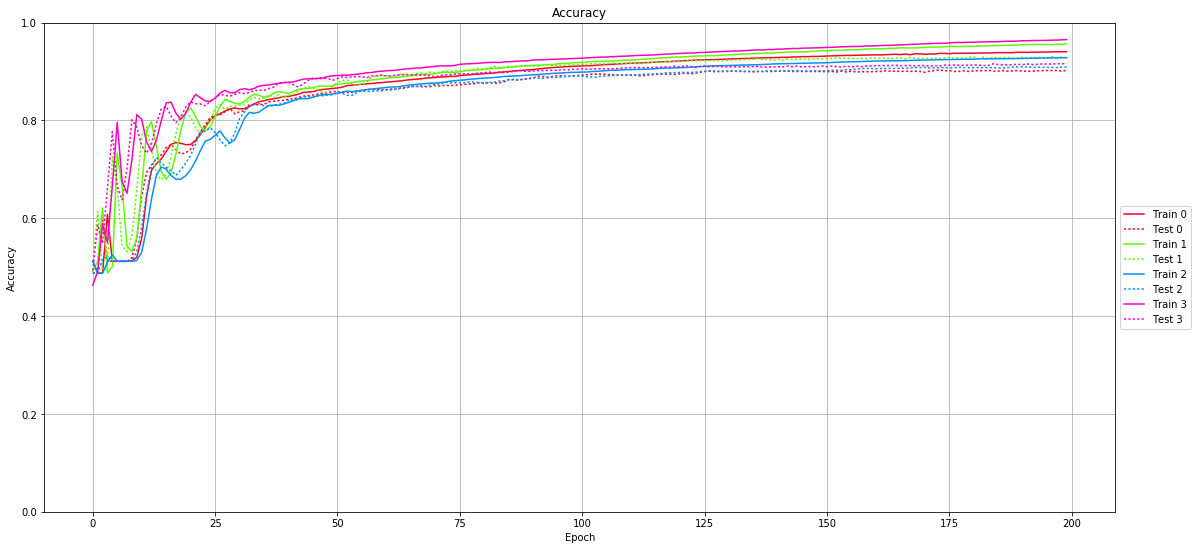

In [16]:
plot_acc(history)

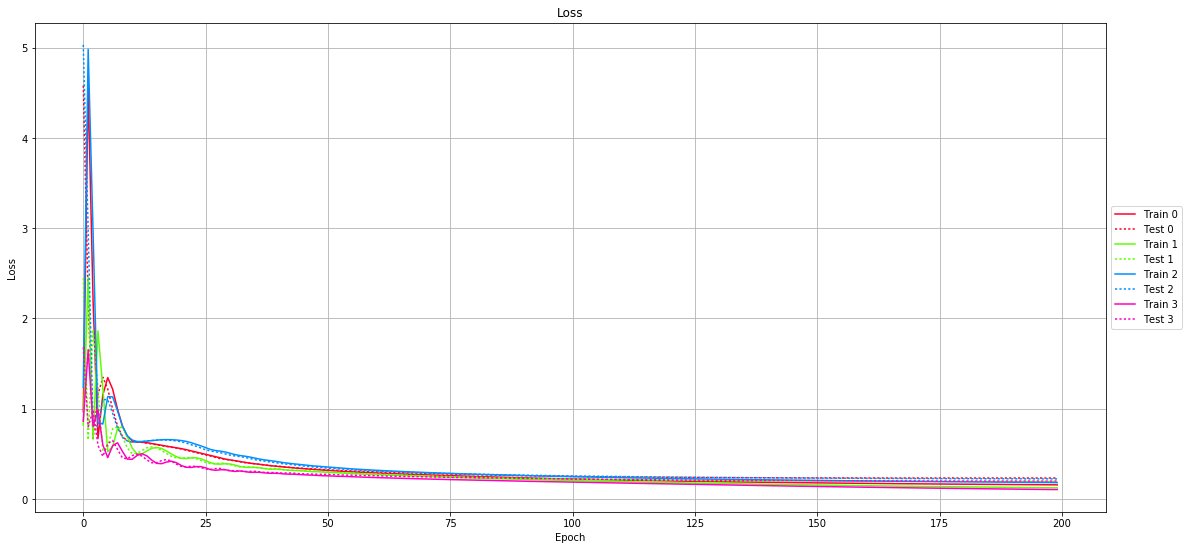

In [17]:
plot_loss(history)

In [20]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


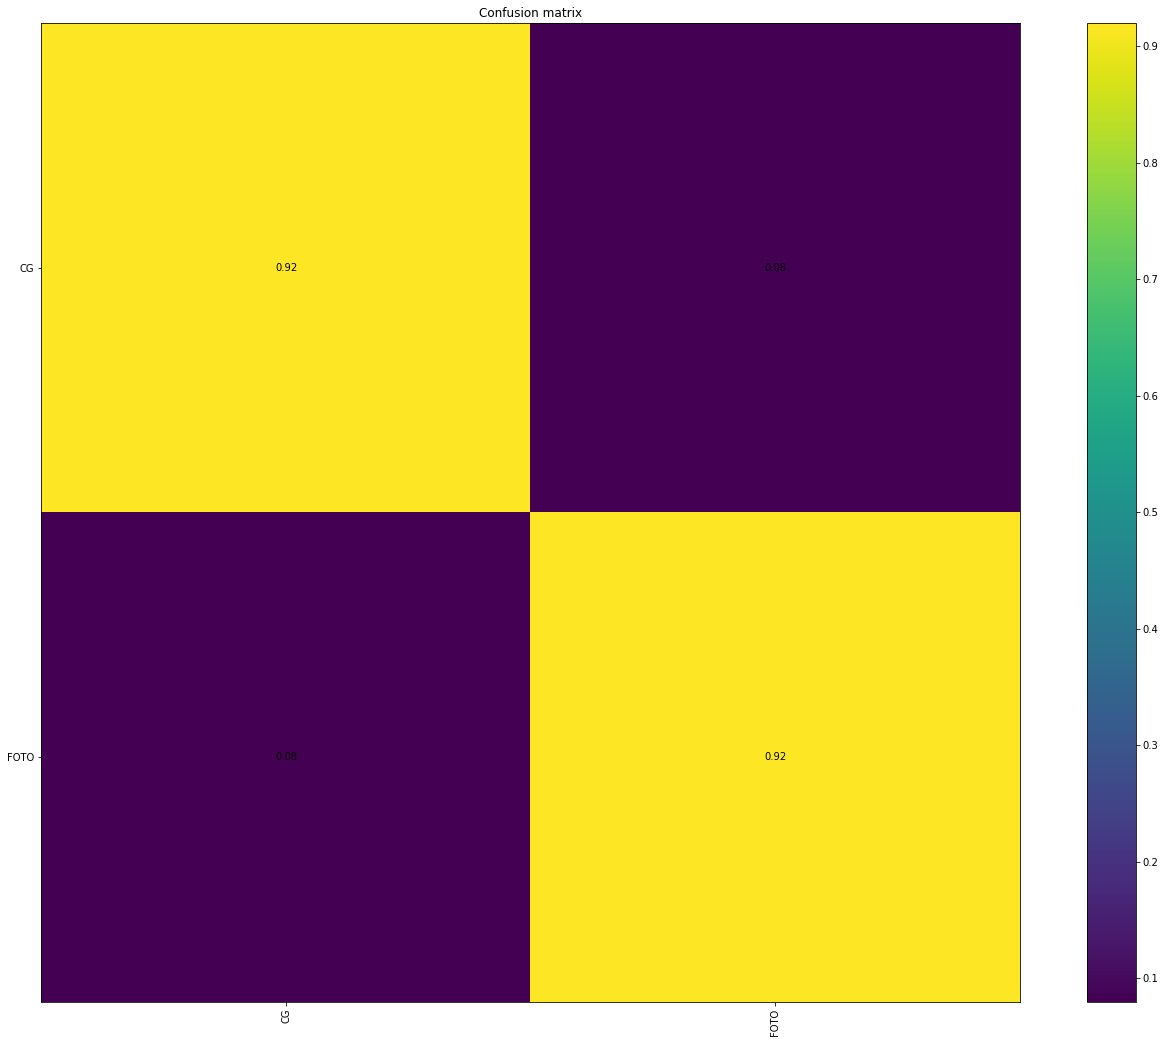

In [21]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()